# Dan's code: fitting a GP to data.

In [64]:
%matplotlib inline

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [66]:
clusters = pd.read_csv("../data/dbf12.csv")
bench = pd.read_csv("../data/Gyro_Benchmark-Field_Stars.csv")
bench = bench.iloc[bench.Age.values > 0.]
k = pd.read_csv("../data/mcquillan_kinematic_ages.csv")
k_lucy = pd.read_csv("../data/Gyrokinage2020_Prot.csv")
kl = pd.DataFrame(dict({"kepid": k_lucy.kepid.values,
                        "kin_age_lucy": k_lucy.kin_age.values,
                        "kin_age_err": k_lucy.kin_age_err.values}))
k = pd.merge(k, kl, on="kepid", how="left")

# Remove subgiants and photometric binaries
kin = k.iloc[k.flag.values == 1]
subs = (kin.bprp_dered.values < 1.5) & (kin.kinematic_age.values > 6)
kin = kin.iloc[~subs]

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0, 0.5, '$\\mathrm{P_{rot}~[days]}$')

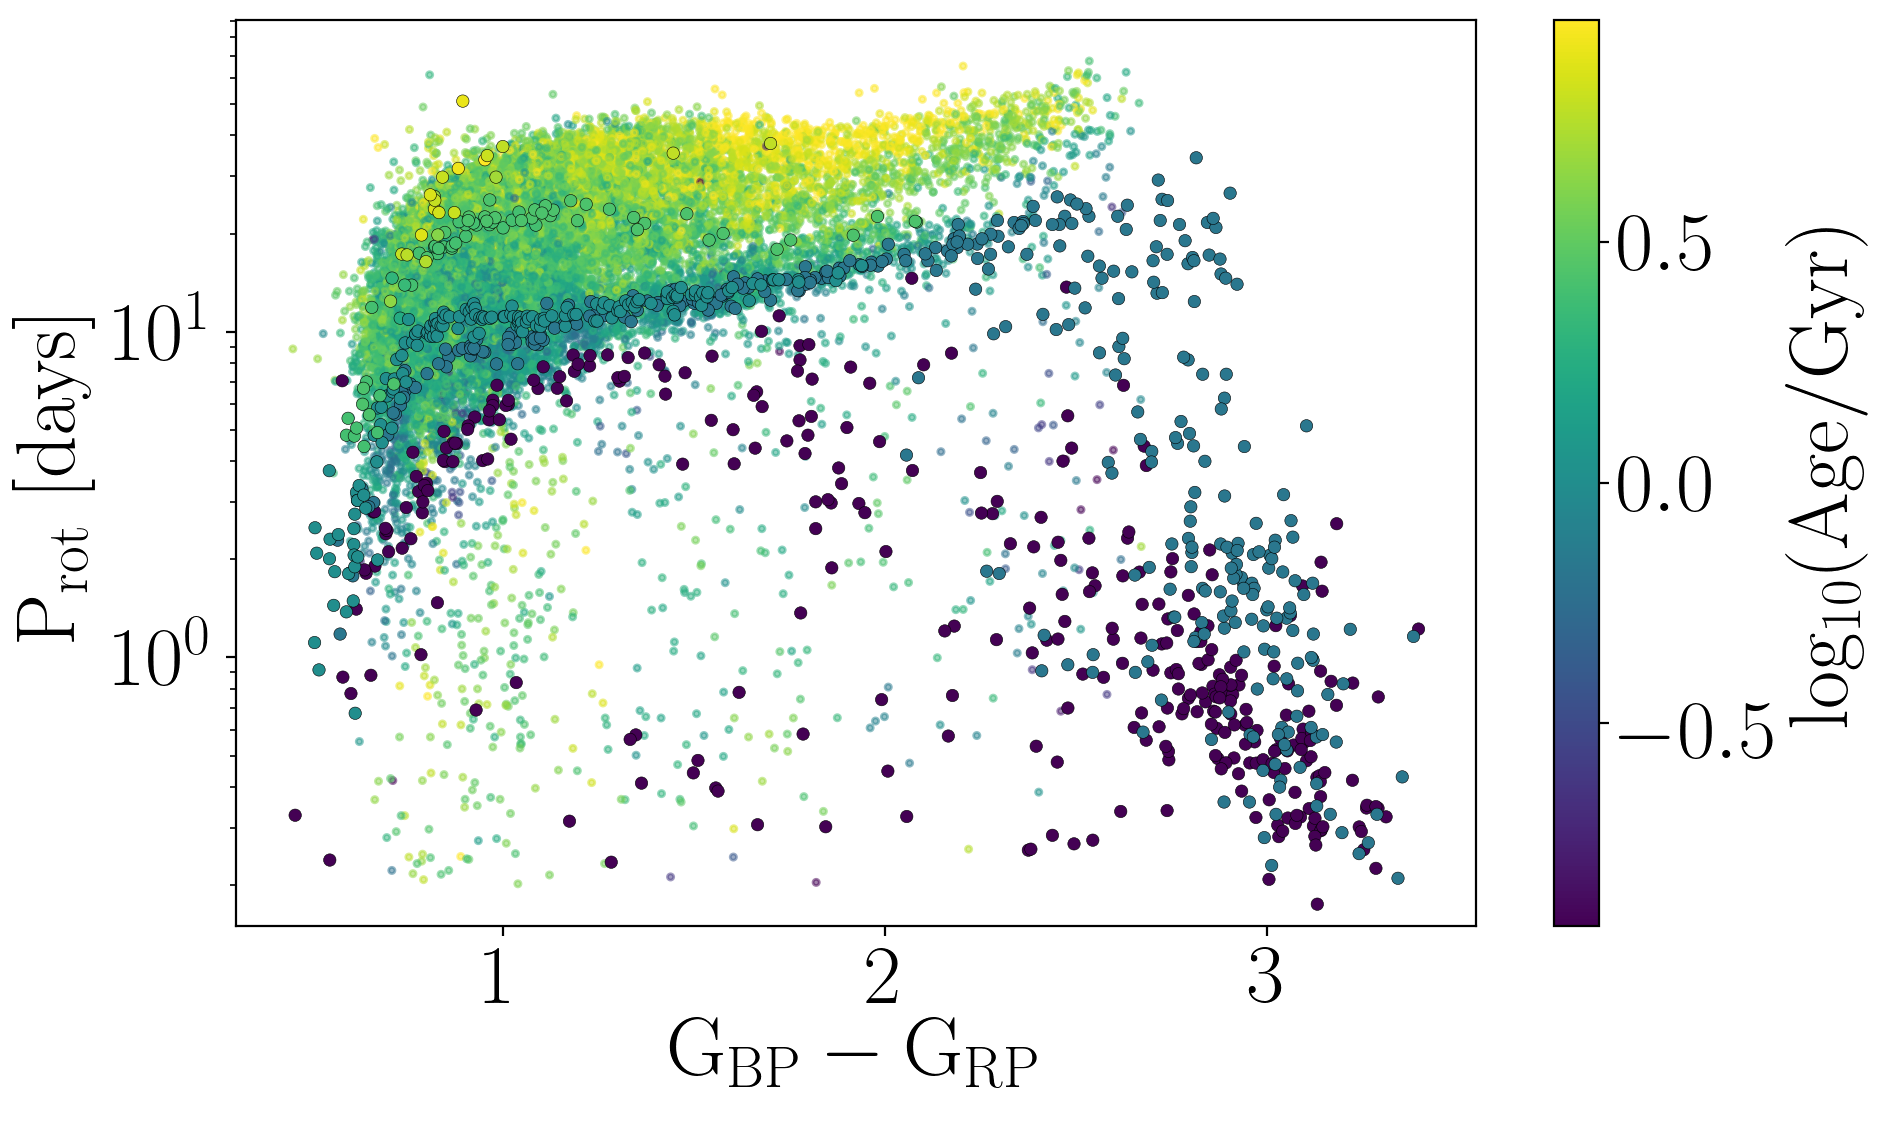

In [67]:
fig = plt.figure(figsize=(10, 6), dpi=200)
vmin, vmax = np.log10(min(clusters.age_gyr)), np.log10(max(bench.Age))
plt.scatter(kin.bprp_dered, kin.Prot, c=np.log10(kin.kin_age_lucy),  #kinematic_age),
           s=5, alpha=.5, vmin=vmin, vmax=vmax)
plt.scatter(clusters["(BP-RP)0"], clusters.prot, c=np.log10(clusters.age_gyr),
            s=20, vmin=vmin, vmax=vmax, edgecolor="k", lw=.2)
plt.scatter(bench["BP-RP"], bench.Prot, c=np.log10(bench.Age),
            s=20, vmin=vmin, vmax=vmax, edgecolor="k", lw=.2)
plt.yscale("log")
plt.colorbar(label="$\mathrm{log_{10}(Age/Gyr)}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")

For now, let's take out the cluster M dwarfs and the outliers in the Pleiades.

In [232]:
# Do all sorts of cuts.
ms = (clusters["(BP-RP)0"].values > 1.5) & (clusters.prot.values < 11)
not_fast = (clusters.prot.values[~ms] > 1) & (clusters["(BP-RP)0"].values[~ms] < 2.7) & (clusters["(BP-RP)0"].values[~ms] < 2.2)
no_pleiades = clusters.age_gyr.values[~ms][not_fast] > 0.2
old = (kin.age.values > .7) & (kin.bprp_dered.values > 1.7)
fin = np.isfinite(kin.kin_age_lucy.values[old]) & np.isfinite(kin.bprp_dered.values[old]) & np.isfinite(kin.Prot.values[old])
sub_sample = 3

Text(0, 0.5, '$\\mathrm{P_{rot}~[days]}$')

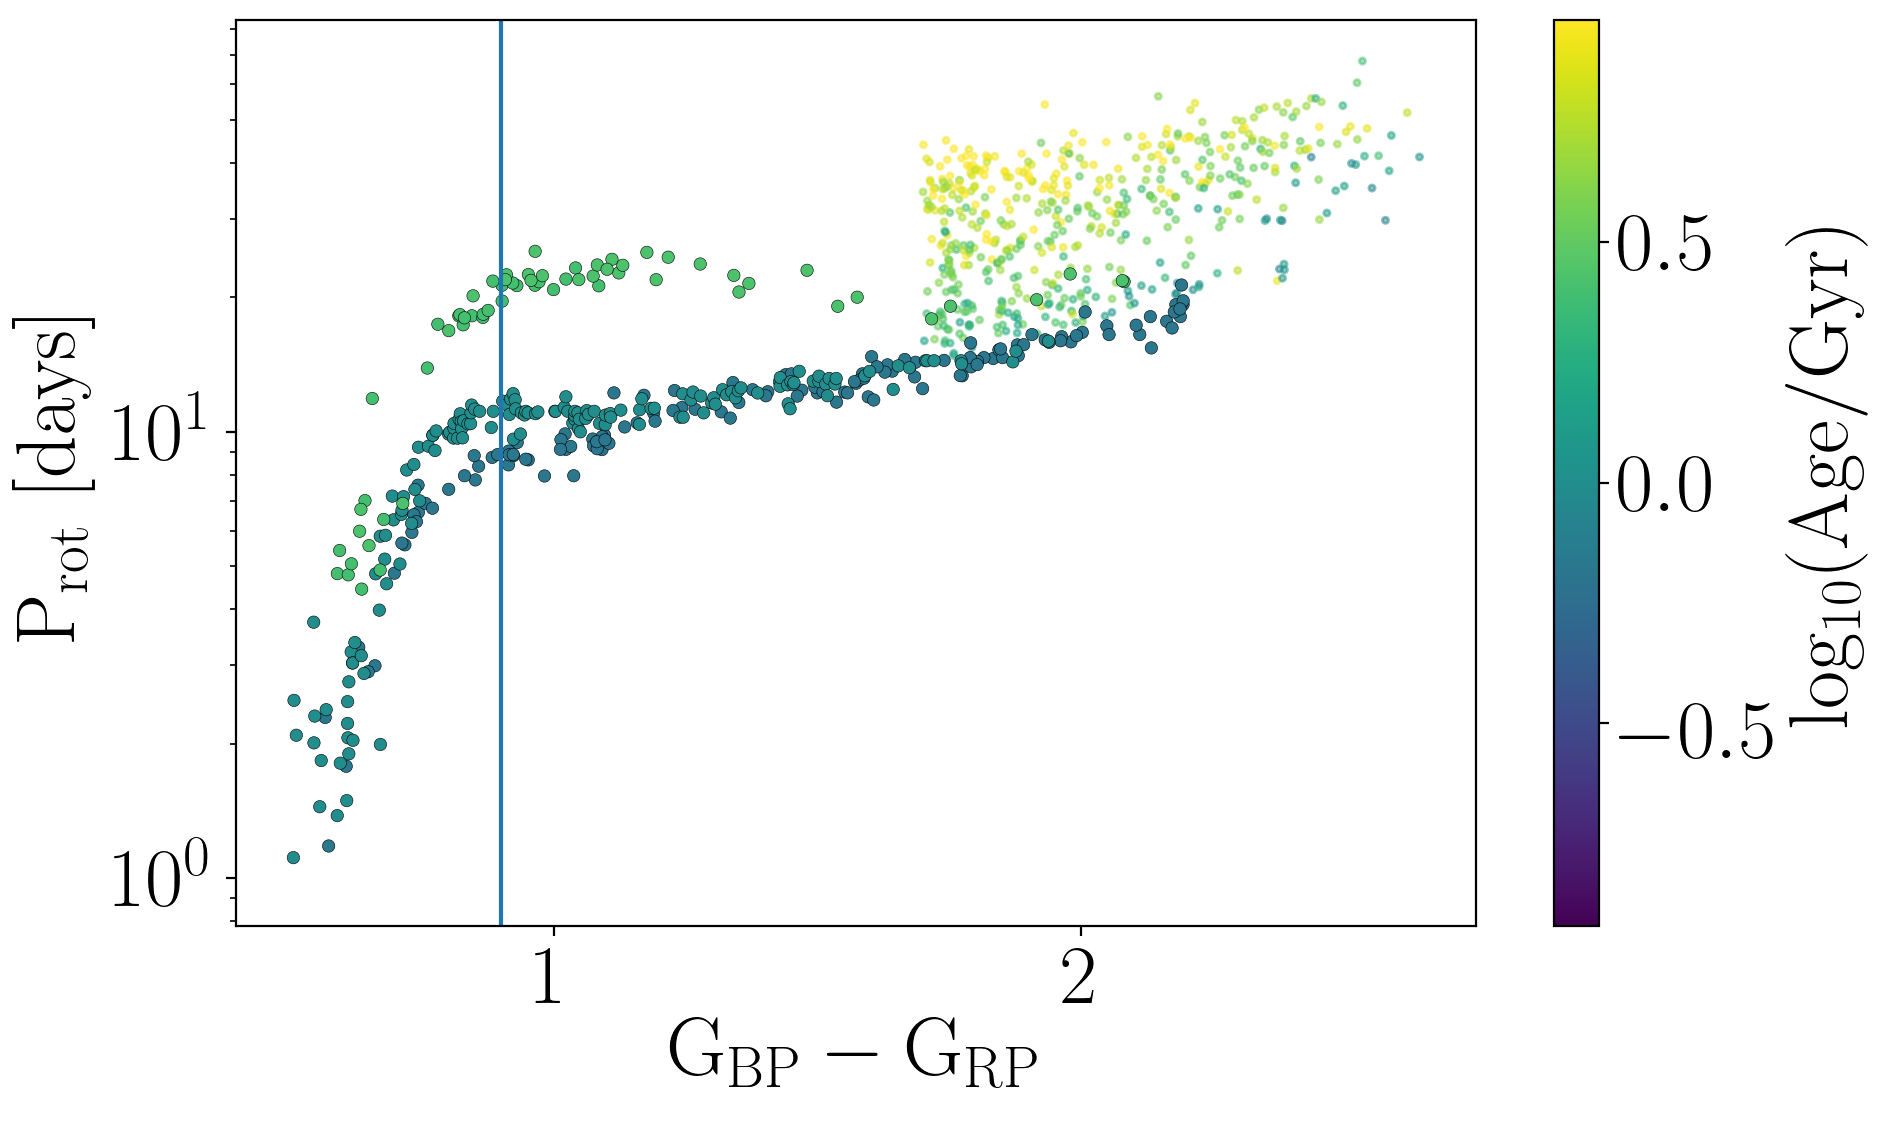

In [233]:
fig = plt.figure(figsize=(10, 6), dpi=200)
vmin, vmax = np.log10(min(clusters.age_gyr)), np.log10(max(bench.Age))

plt.scatter(kin.bprp_dered.values[old][fin][::sub_sample], kin.Prot.values[old][fin][::sub_sample],
            c=np.log10(kin.kin_age_lucy.values[old][fin][::sub_sample]),
           s=5, alpha=.5, vmin=vmin, vmax=vmax)

plt.scatter(clusters["(BP-RP)0"].values[~ms][not_fast][no_pleiades], clusters.prot.values[~ms][not_fast][no_pleiades], 
            c=np.log10(clusters.age_gyr.values[~ms][not_fast][no_pleiades]),
            s=20, vmin=vmin, vmax=vmax, edgecolor="k", lw=.2)

plt.axvline(.9)

plt.yscale("log")
plt.colorbar(label="$\mathrm{log_{10}(Age/Gyr)}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")

Assemble the data for fitting.

Calculate the rotation period uncertainties by calculating scatter.

In [70]:
import astropy.stats as aps
from tqdm.notebook import tqdm
from tqdm import trange

def subtract_lil_line(x, y, order):
    pv = np.polyfit(x, y, order)
    return y - np.polyval(pv, x), pv

def test_subtract_lil_line():
    x = np.linspace(0, 5, 10000)
    np.random.seed(42)
    y = 5*x + 4 + 2*x**2 + np.random.randn(len(x))
    y_corrected, _ = subtract_lil_line(x, y, 3)
    assert np.isclose(np.std(y_corrected), 1, atol=.1)
    
test_subtract_lil_line()

100%|██████████| 1000/1000 [00:05<00:00, 191.03it/s]


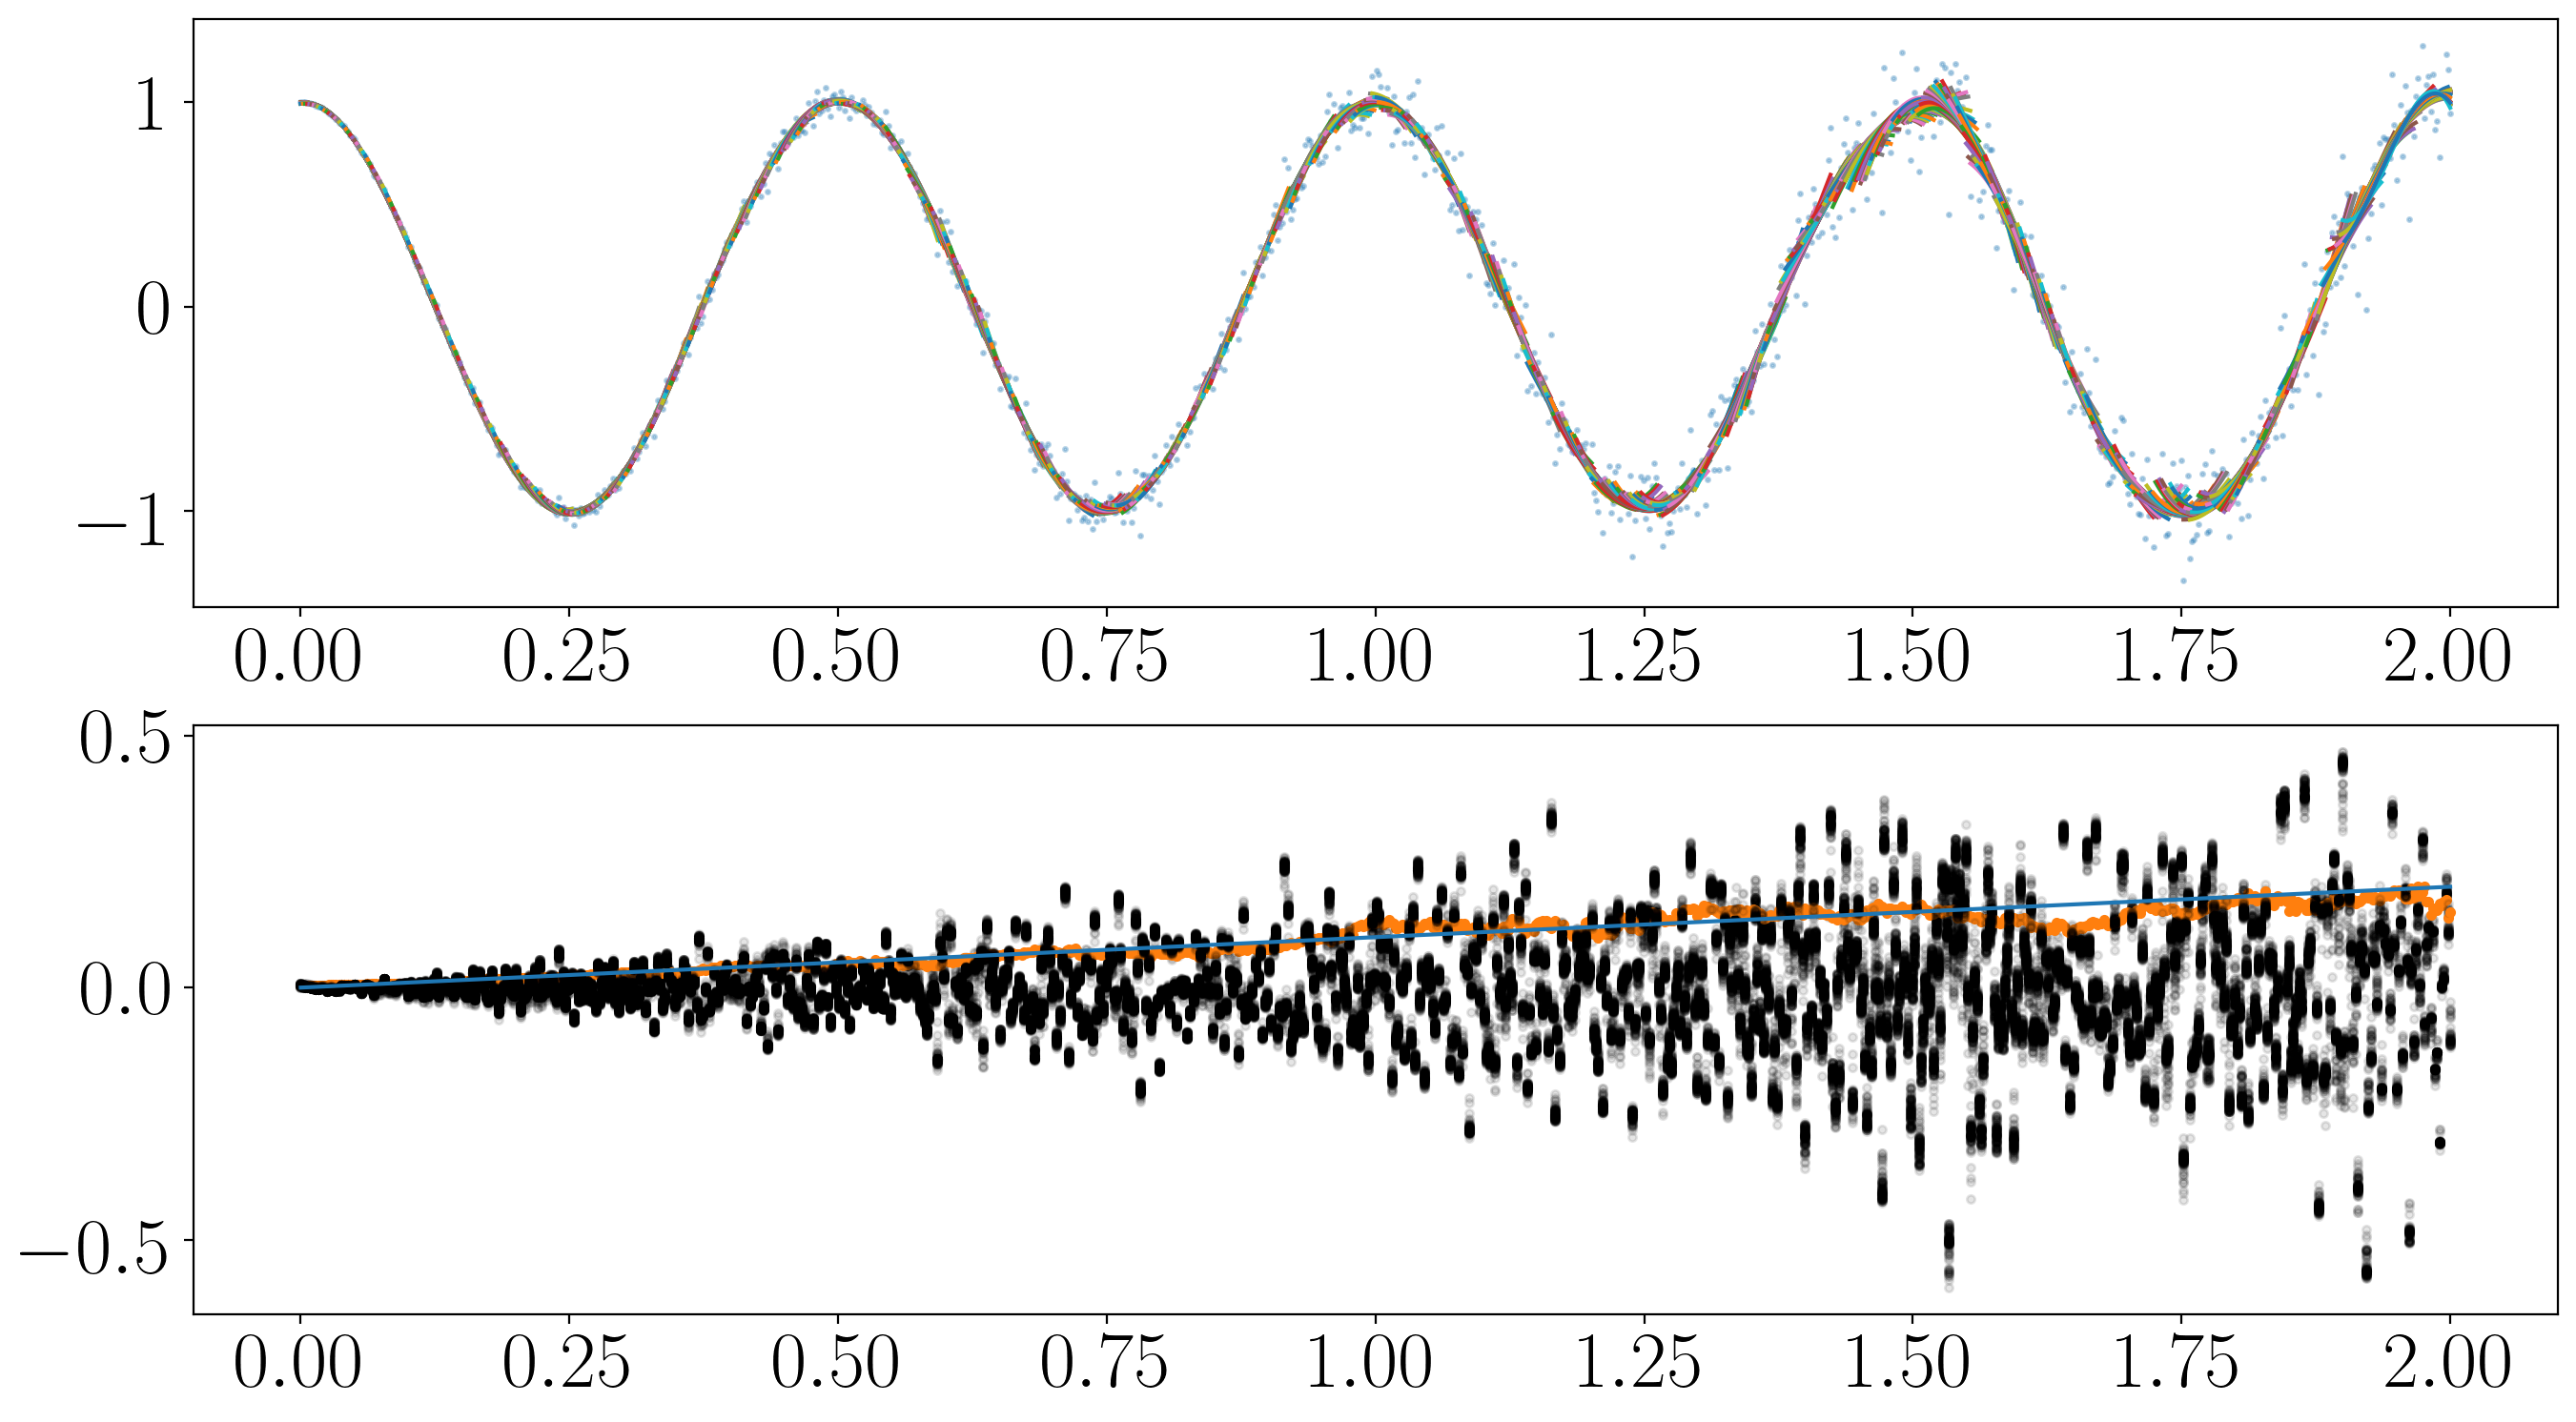

In [71]:
def running_scatter(xval, yval, width=.1):
    assert len(xval) == len(yval)
    
    # For each data point, select stars within an x value range of width.
    stds = np.empty(len(yval))
    for i in trange(len(xval)):
        m = abs(xval[i] - xval) < width
        y_corrected, p = subtract_lil_line(xval[m], yval[m], 3)
        stds[i] = aps.median_absolute_deviation(y_corrected) * 1.5
    return stds

def test_running_scatter():
    
    npoints = 1000
    xsim = np.linspace(0, 2, npoints)
    true_yerr = np.random.randn(npoints)*.1*xsim
    ysim = .5 * xsim + true_yerr
    ysim = np.cos(xsim*2*np.pi*2) + true_yerr
    fig = plt.figure(figsize=(16, 9), dpi=200)
    ax = fig.add_subplot(211)
    ax1 = fig.add_subplot(212)
    ax.plot(xsim, ysim, ".", alpha=.3, ms=3, zorder=0)
    
    # For each data point, select stars within an x value range of width.
    stds = np.empty(len(ysim))
    for i in trange(len(xsim)):
        width = .1
        m = abs(xsim[i] - xsim) < width
#         while sum(m) < 10:
#             width += .1
#             m = abs(xsim[i] - xsim) < width
        y_corrected, p = subtract_lil_line(xsim[m], ysim[m], 3)
        stds[i] = aps.median_absolute_deviation(y_corrected) * 1.5
        ax.plot(xsim[m], np.polyval(p, xsim[m]))
        ax1.plot(xsim[m], y_corrected, "k.", alpha=.1)
        ax1.plot(xsim[i], stds[i], "C1.")
    ax1.plot(xsim, xsim*.1)
    
test_running_scatter()

In [220]:
# x is either color or Teff
# x = np.concatenate((clusters["(BP-RP)0"].values[~ms][not_fast], kin.bprp_dered.values[old][::sub_sample]))
# prot = np.concatenate((clusters.prot.values[~ms][not_fast], kin.Prot.values[old][::sub_sample]))
# age = np.concatenate((clusters.age_gyr.values[~ms][not_fast], kin.kin_age_lucy.values[old][::sub_sample]))

x = clusters["(BP-RP)0"].values[~ms][not_fast][no_pleiades]
prot = clusters.prot.values[~ms][not_fast][no_pleiades]
age = clusters.age_gyr.values[~ms][not_fast][no_pleiades]

no_nan = np.isfinite(x) & np.isfinite(prot) & np.isfinite(age) & (age > 0) & (prot > 0)
x, prot, age = x[no_nan], prot[no_nan], age[no_nan]

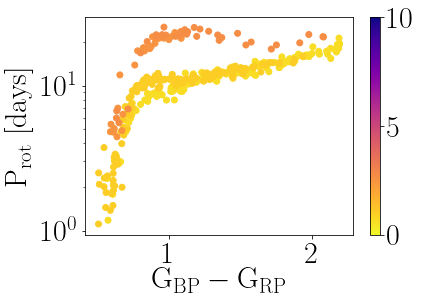

In [221]:
plt.scatter(x, prot, c=age, vmin=0, vmax=10, cmap="plasma_r")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.yscale("log")
plt.colorbar();

100%|██████████| 35/35 [00:00<00:00, 2034.18it/s]


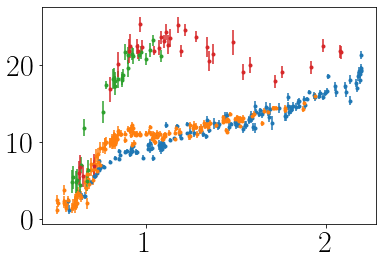

In [224]:
yerrors = []
for a in np.unique(age):
    age_mask = age == a
    
#     fig = plt.figure(figsize=(16, 9), dpi=200)
#     ax = fig.add_subplot(211)
#     ax1 = fig.add_subplot(212)
#     ax.plot(x[age_mask], prot[age_mask], "k.", ms=3, zorder=0)
    
    x_, y_ = x[age_mask], prot[age_mask]
    stds = np.empty(len(y_))
    for i in trange(len(x_)):
        width = .1
        m = abs(x_[i] - x_) < width
        while sum(m) < 10:
            width += .1
            m = abs(x_[i] - x_) < width
        y_corrected, p = subtract_lil_line(x_[m], y_[m], 2)
        stds[i] = aps.median_absolute_deviation(y_corrected) * 1.5
#         ax.plot(x_[m], np.polyval(p, x_[m]), alpha=.1)
#         ax1.plot(x_[m], y_corrected, "k.", alpha=.1)
#         ax1.plot(x_[i], stds[i], "C1.")
    
    plt.errorbar(x[age_mask], prot[age_mask], yerr=stds, fmt=".")
    yerrors.append(stds)
    
yerrors = np.array([i for j in yerrors for i in j])
#     assert 0

Sort and format data

In [239]:
# Add the Sun
x = np.concatenate((x, np.array([.82])))
age = np.concatenate((age, np.array([4.62])))
prot = np.concatenate((prot, np.array([26.])))
yerrors = np.concatenate((yerrors, np.array([1.])))

# Add the kinematic ages
x = np.concatenate((x, kin.bprp_dered.values[old][fin][::sub_sample]))
prot = np.concatenate((prot, kin.Prot.values[old][fin][::sub_sample]))
age = np.concatenate((age, kin.kin_age_lucy.values[old][fin][::sub_sample]))
yerrors = np.concatenate((yerrors, prot*.5))

inds = np.argsort(x)
x1 = np.array(x[inds])
x2 = np.log(np.array(age[inds]))
y = np.log(np.array(prot[inds]))
y_err = yerrors[inds]/prot[inds]
# y_err = np.ones_like(y)*.1

mu1 = np.mean(x1)
sd1 = np.std(x1)
mu2 = np.mean(x2)
sd2 = np.std(x2)

x2_min = np.min(x2)

# if using color:
xp1 = np.linspace(x1.min() - .2, x1.max() + .2, 1000)

xp2 = np.linspace(x2.min(), x2.max(), 1000)
xg1 = np.linspace(x1.min(), x1.max(), 5)
# xg2 = np.linspace(x2.min(), x2.max(), 7)
xg2 = np.linspace(x2.min(), x2.max(), 10)  # More age lines

<ErrorbarContainer object of 3 artists>

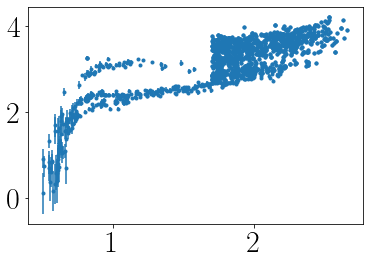

In [240]:
plt.errorbar(x1, y, yerr=y_err, fmt=".")

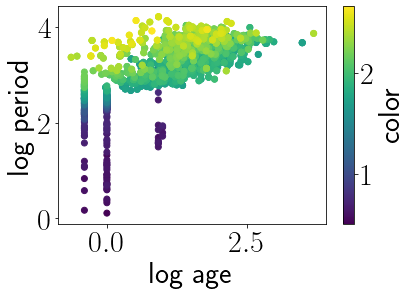

In [241]:
plt.scatter(x2, y, c=x1)
for i, x2_ref in enumerate(xg2):
    plt.axvline(x2_ref)
plt.xlabel("log age")
plt.ylabel("log period")
plt.colorbar(label="color")

Text(0.5, 0, 'color or log(age)')

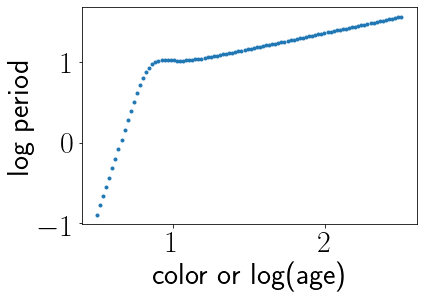

In [242]:
slope_low = 5.45  # Slope below the break
slope_high = .4  # Slope above the break
teff_break = 0.83
log_period_break_c = .1
log_period_break_m = 2.25
log_period_break_b = .2
log_smooth = 2.73   # higher number = less smooth
smooth = np.exp(log_smooth)

def get_log_period_break(x2):
    """
    3rd-order polynomial describing relationship between period and age.
    period = c*logage**2 + m*logage + b
    """
#     return log_period_break_c * (x2 - x2_min)**2 + log_period_break_m * (x2 - x2_min) + log_period_break_b
    return (x2 - x2_min) * .5
        
# Mean model
def get_mean_model(x1, x2):
    """
    Predict the period at given values of color and age.
    """
    delta = x1 - teff_break   # distance to the break.
    brk = get_log_period_break(x2)  # Get the period at this age
    
    # Smoothed broken power-law.
    slope = slope_low / (1 + np.exp(smooth * delta)) + slope_high / (1 + np.exp(-smooth * delta))
    return slope * delta + brk  # separable relation: brk is age model, slope * delta is color model. 

N = 100
_x1 = np.linspace(.5, 2.5, N)
_x2 = np.log(np.linspace(.5, 4, N))
x2_min = np.min(_x2)
p = get_mean_model(_x1, np.log(3))
# p = get_mean_model(1.5, _x2)
# p = get_log_period_break(_x2)
plt.plot(_x1, p, ".")
plt.ylabel("log period")
plt.xlabel("color or log(age)")

In [243]:
with pm.Model() as model:
    # x1 is color
    # x2 is age
    # y is period
    
    # Parameters to infer.
    teff_break = pm.Normal("teff_break", mu=0.9, sigma=.3)                     # the break in temperature (actually color)
    log_period_break_c = pm.Normal("log_period_break_c", mu=0.0, sd=5)         # The weight of the x^2 term
    log_period_break_m = pm.Normal("log_period_break_m", mu=0.0, sd=5)         # The weight of the x term
    log_period_break_b = pm.Normal("log_period_break_b", mu=np.log(10), sd=5)  # The constant term
    log_smooth = pm.Normal("log_smooth", mu=np.log(0.01), sigma=10.0)          # The smoothness of the break. (lower is smoother)
    smooth = tt.exp(log_smooth)
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)                        # The slope below the break
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)                      # The slope above the break
    log_s2 = pm.Normal("log_s2", mu=1.0, sd=10.0)                              # The log-variance of the rotation period data. 
    
    def get_log_period_break(x2):
        """
        3rd-order polynomial describing relationship between period and age.
        period = c*logage**2 + m*logage + b
        """
        return log_period_break_c * (x2 - x2_min)**2 + log_period_break_m * (x2 - x2_min) + log_period_break_b
    
    # Mean model
    def get_mean_model(x1, x2):
        """
        Predict the period at given values of color and age.
        Use a smoothed broken power law for the period - color relation.
        Use get_log_period_break for the period - age relation.
        """
        delta = x1 - teff_break
        brk = get_log_period_break(x2)  # Get the period at this age
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + brk
    
    mean_model = get_mean_model(x1, x2)
    pm.Deterministic("mean_model", mean_model)
    
    # GP parameters
    log_amp = pm.Normal("log_amp", mu=np.log(np.var(y)), sigma=10.0)
    log_ell = pm.Normal("log_ell1", mu=0.0, sigma=10.0, shape=2)
    
    def get_K(x1, x2, xp1=None, xp2=None):
        X = np.vstack(((x1 - mu1) / sd1, (x2 - mu2) / sd2))
        
        if xp1 is None:
            dX = (X[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
        else:
            Xp = np.vstack(((xp1 - mu1) / sd1, (xp2 - mu2) / sd2))
            dX = (Xp[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
            
        K = tt.exp(log_amp - 0.5 * r2)
        return K
    
    K = get_K(x1, x2)
    K = tt.inc_subtensor(K[np.diag_indices(len(y))], tt.exp(log_s2) + np.zeros_like(y))
#     K = tt.inc_subtensor(K[np.diag_indices(len(y))], tt.exp(log_s2) + y_err)
    
    alpha = tt.slinalg.solve(K, y - mean_model)
    for i, x2_ref in enumerate(xg2):
        pred_model = get_mean_model(xp1, x2_ref)
        Kp = get_K(x1, x2, xp1, x2_ref + np.zeros_like(xp1))
        pred = tt.dot(Kp, alpha) + pred_model
        pm.Deterministic("pred_{0}".format(i), pred)
    
    # Likelihood
    pm.MvNormal("obs", mu=mean_model, cov=K, observed=y)
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [teff_break, log_period_break_m, log_period_break_b, log_period_break_c])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [log_s2, log_amp, log_ell])
    map_soln = xo.optimize(map_soln)

print("done")

ValueError: array must not contain infs or NaNs

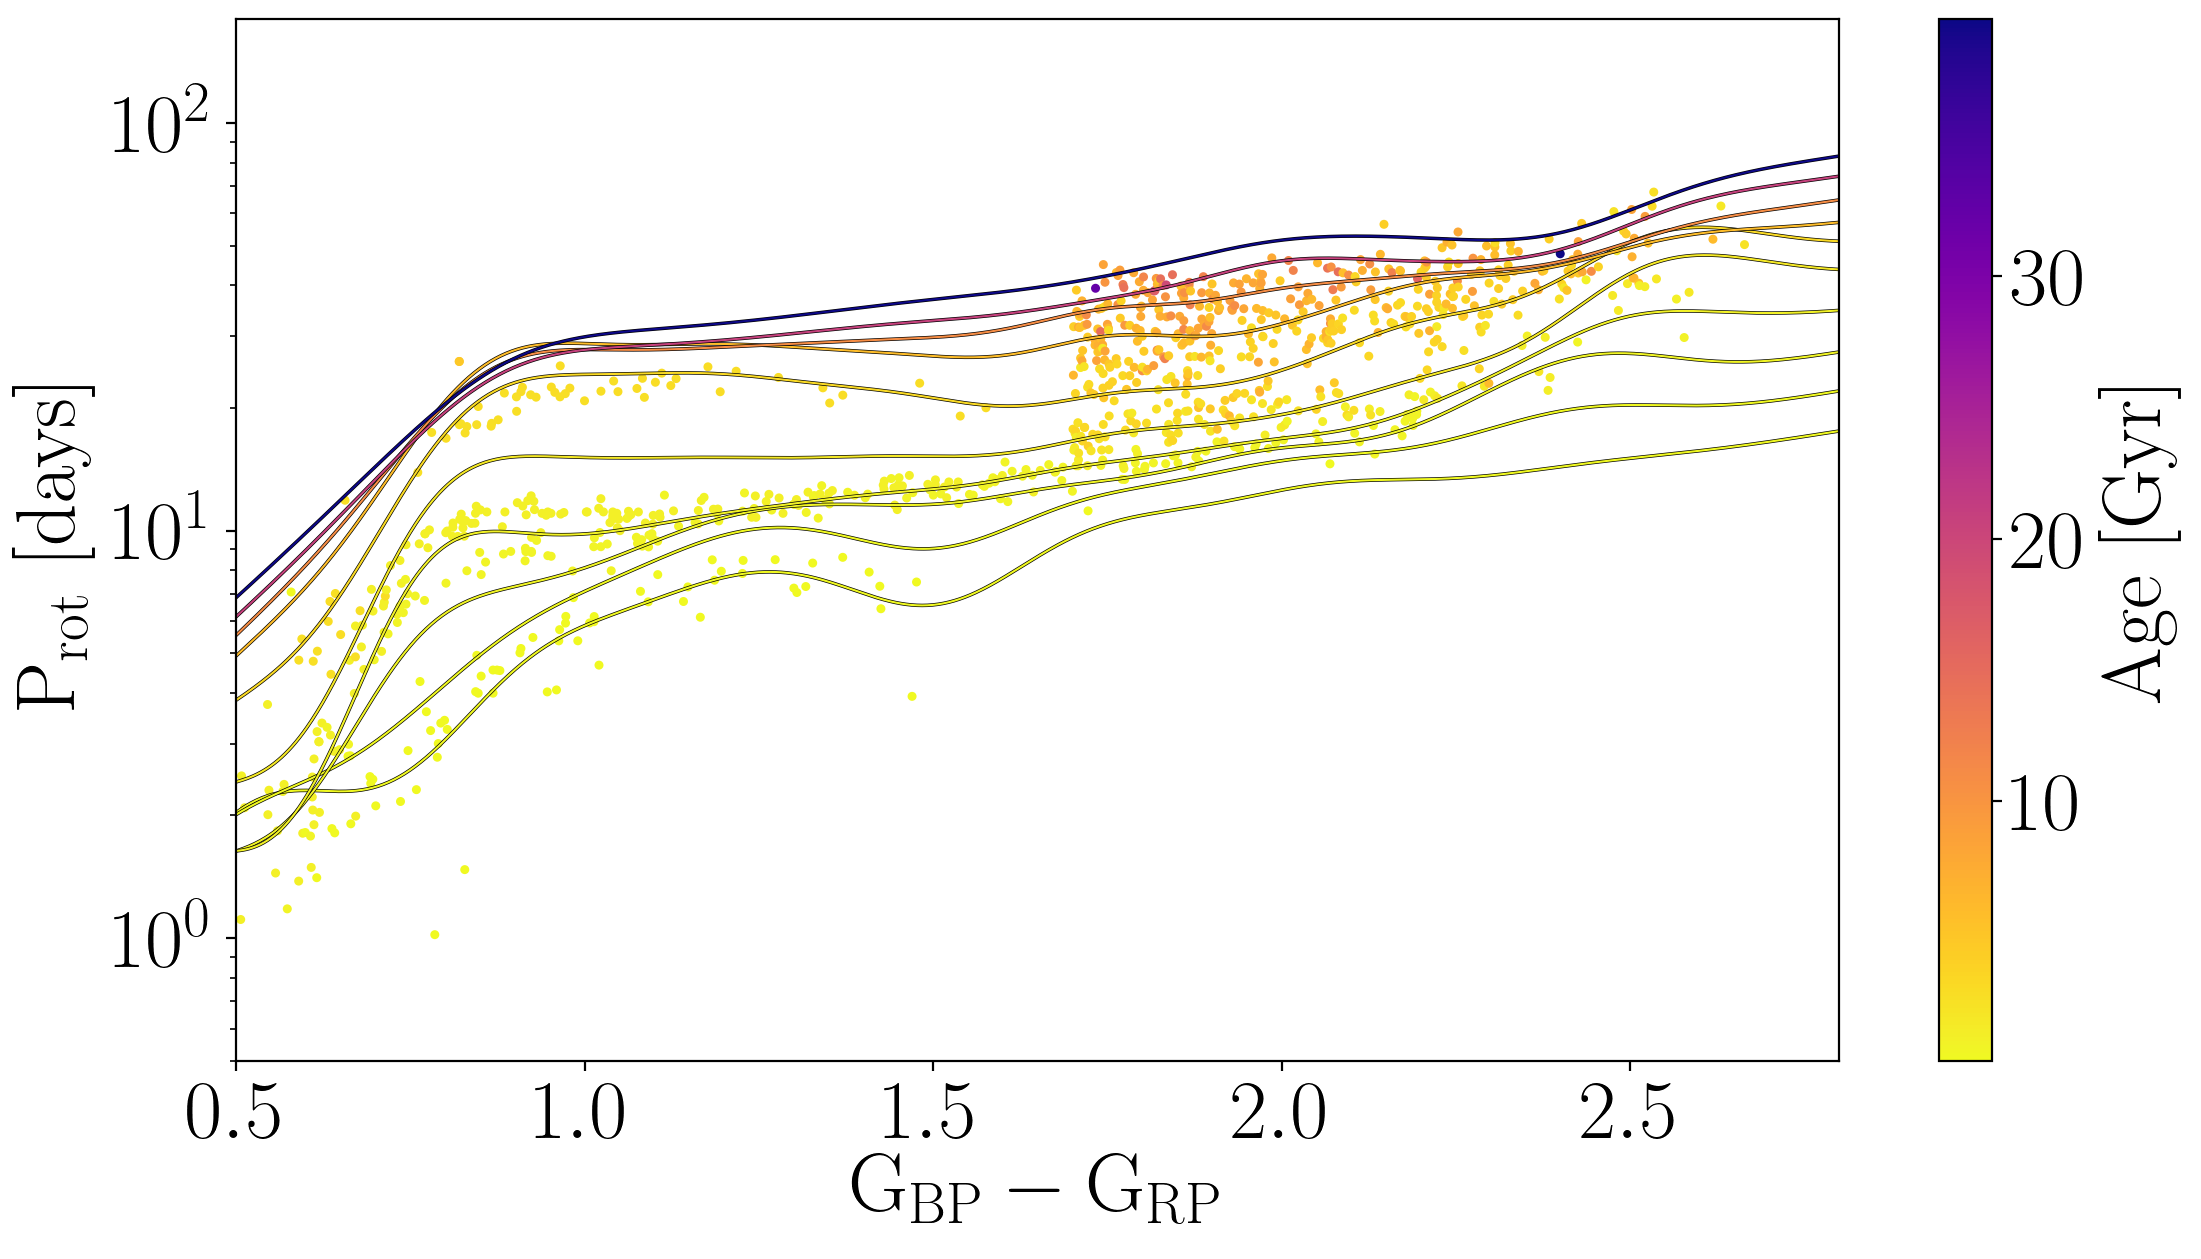

In [219]:
cmap = matplotlib.cm.get_cmap("plasma_r")

vmin = np.exp(x2).min()
vmax = np.exp(x2).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

plt.figure(figsize=(12, 7), dpi=200)
# plt.plot(kin.bprp_dered, kin.Prot, ".", color=".7", zorder=0, ms=.5, rasterized=True)
# plt.scatter(x, prot, c=age, vmin=0, vmax=10, s=5, cmap="plasma_r")
# plt.scatter(x, prot, c=age, vmin=vmin, vmax=vmax, s=5, cmap="plasma_r")
# plt.errorbar(x1, np.exp(y), yerr=y_err*np.exp(y), fmt="k.", alpha=.5, zorder=0)
plt.scatter(x1, np.exp(y), c=np.exp(x2), vmin=vmin, vmax=vmax, s=5, cmap="plasma_r")

for i in range(len(xg2)):
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(xg2[i]), lw=0.75)

plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.ylim(0.5, 180)
plt.yscale("log")
plt.colorbar(label="$\mathrm{Age~[Gyr]}$");
plt.xlim(.5, 2.8)
plt.tight_layout()